In [0]:
!ls

hymenoptera_data  hymenoptera_data.zip	sample_data


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x586d2000 @  0x7f97a78902a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()
% matplotlib inline

In [0]:
# Data augmentation and normalization for training.
# And normalization for validation.

data_transforms={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x] )  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

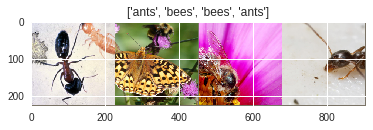

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
#train a model. Here, we will illustrate:

    #Scheduling the learning rate
    #Saving the best model

def train_model( model, criterion, optimizer, scheduler, num_epochs=25):
  
  since= time.time()
  
  best_model_wts=copy.deepcopy(model.state_dict())
  best_acc=0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
  
    for phase in ['train', 'val']:
      if phase=='train':
        scheduler.step()
        model.train()
      else :
        model.eval()
        
      running_loss=0.0
      running_corrects=0
      
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
             # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
                
    print()
          
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
  model.load_state_dict(best_model_wts)
  return model
  


In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 in every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 60941445.31it/s]


In [0]:
!pip install pillow==4.1.1 # to resolve the error that PIL.Image has no attribute register extensions.
%reload_ext autoreload
%autoreload
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

    100% |████████████████████████████████| 5.7MB 6.9MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
Epoch 0/24
----------
train Loss: 0.5525 Acc: 0.7008
val Loss: 0.2748 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5213 Acc: 0.7828
val Loss: 0.3032 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4820 Acc: 0.8033
val Loss: 0.2230 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4598 Acc: 0.8279
val Loss: 0.2267 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4521 Acc: 0.8115
val Loss: 0.7474 Acc: 0.7582

Epoch 5/24
----------
train Loss: 0.4959 Acc: 0.8115
val Loss: 0.8136 Acc: 0.7516

Epoch 6/24
----------
train Loss: 0.4997 Acc: 0.8074
val Loss: 0.2539 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2952 Acc: 0.8811
val Loss: 0.2334 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3489 Acc: 0.8648
val Loss: 0.2129 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3439 Acc: 0.8484
val Loss: 0.2269 Acc: 

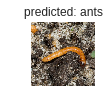

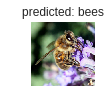

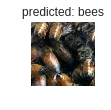

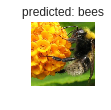

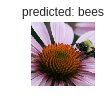

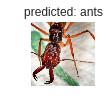

In [0]:
visualize_model(model_ft)

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6131 Acc: 0.6721
val Loss: 0.2897 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4591 Acc: 0.7869
val Loss: 0.3373 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5412 Acc: 0.7828
val Loss: 0.1976 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5340 Acc: 0.7500
val Loss: 0.2036 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4659 Acc: 0.8156
val Loss: 0.2022 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4495 Acc: 0.8156
val Loss: 0.1922 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3785 Acc: 0.8320
val Loss: 0.1954 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3465 Acc: 0.8484
val Loss: 0.2104 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3812 Acc: 0.8320
val Loss: 0.1975 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3753 Acc: 0.8525
val Loss: 0.1954 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3677 Acc: 0.8279
val Loss: 0.2460 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3553 Acc: 0.8525
val Loss: 0.2080 Acc: 0.9346

Ep

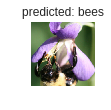

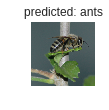

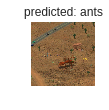

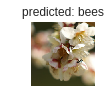

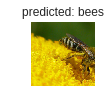

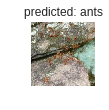

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()